In [11]:
# Imports & dataset load
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.datasets import imdb
from sklearn.metrics import confusion_matrix, classification_report

os.makedirs("images", exist_ok=True)

num_words = 10000
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=num_words)

print("Loaded:", len(train_data), "train examples and", len(test_data), "test examples")

Loaded: 25000 train examples and 25000 test examples


In [12]:
# Inspecting and decoding data
word_index = imdb.get_word_index()
reverse_word_index = dict((value, key) for (key, value) in word_index.items())

def decode_review(seq):
    return " ".join([reverse_word_index.get(i - 3, "?") for i in seq])

print("First review token IDs:", train_data[0][:30])
print("First label:", train_labels[0])
print("Decoded review (preview):", decode_review(train_data[0])[:300], "...")


First review token IDs: [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480]
First label: 1
Decoded review (preview): ? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there wa ...


In [13]:
# Vectorizing sequences
def vectorize_sequences(sequences, dimension=num_words):
    results = np.zeros((len(sequences), dimension), dtype="float32")
    for i, sequence in enumerate(sequences):
        for j in sequence:
            if j < dimension:
                results[i, j] = 1.0
    return results

x_train = vectorize_sequences(train_data)
x_test  = vectorize_sequences(test_data)
y_train = np.asarray(train_labels).astype("float32")
y_test  = np.asarray(test_labels).astype("float32")

print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)


x_train shape: (25000, 10000)
y_train shape: (25000,)


In [14]:
# Building model
def build_model(hidden_layers=2, units=16, activation="tanh", output_act="sigmoid",
                l2_weight=0.0, dropout_rate=0.0, input_shape=(num_words,)):
    model = keras.Sequential()
    if hidden_layers >= 1:
        model.add(layers.Dense(units, activation=activation,
                               kernel_regularizer=regularizers.l2(l2_weight),
                               input_shape=input_shape))
        if dropout_rate > 0:
            model.add(layers.Dropout(dropout_rate))
    for _ in range(hidden_layers - 1):
        model.add(layers.Dense(units, activation=activation,
                               kernel_regularizer=regularizers.l2(l2_weight)))
        if dropout_rate > 0:
            model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(1, activation=output_act))
    return model


In [15]:
# Validation split
x_val = x_train[:10000]
partial_x_train = x_train[10000:]
y_val = y_train[:10000]
partial_y_train = y_train[10000:]

print("partial_x_train shape:", partial_x_train.shape)
print("x_val shape:", x_val.shape)


partial_x_train shape: (15000, 10000)
x_val shape: (10000, 10000)


In [16]:
# Baseline model
baseline = build_model(hidden_layers=2, units=16, activation="tanh")
baseline.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])

history = baseline.fit(partial_x_train, partial_y_train,
                       epochs=20, batch_size=512,
                       validation_data=(x_val, y_val), verbose=2)
history_baseline = history.history


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
30/30 - 3s - 103ms/step - accuracy: 0.7913 - loss: 0.4996 - val_accuracy: 0.8482 - val_loss: 0.3916
Epoch 2/20
30/30 - 1s - 41ms/step - accuracy: 0.8981 - loss: 0.2981 - val_accuracy: 0.8727 - val_loss: 0.3150
Epoch 3/20
30/30 - 1s - 49ms/step - accuracy: 0.9254 - loss: 0.2177 - val_accuracy: 0.8903 - val_loss: 0.2732
Epoch 4/20
30/30 - 2s - 60ms/step - accuracy: 0.9409 - loss: 0.1703 - val_accuracy: 0.8868 - val_loss: 0.2754
Epoch 5/20
30/30 - 2s - 63ms/step - accuracy: 0.9559 - loss: 0.1359 - val_accuracy: 0.8820 - val_loss: 0.2944
Epoch 6/20
30/30 - 1s - 37ms/step - accuracy: 0.9646 - loss: 0.1085 - val_accuracy: 0.8633 - val_loss: 0.3996
Epoch 7/20
30/30 - 1s - 40ms/step - accuracy: 0.9702 - loss: 0.0916 - val_accuracy: 0.8731 - val_loss: 0.3612
Epoch 8/20
30/30 - 1s - 40ms/step - accuracy: 0.9779 - loss: 0.0710 - val_accuracy: 0.8705 - val_loss: 0.4229
Epoch 9/20
30/30 - 1s - 37ms/step - accuracy: 0.9805 - loss: 0.0614 - val_accuracy: 0.8547 - val_loss: 0.4917
Epoch 10/

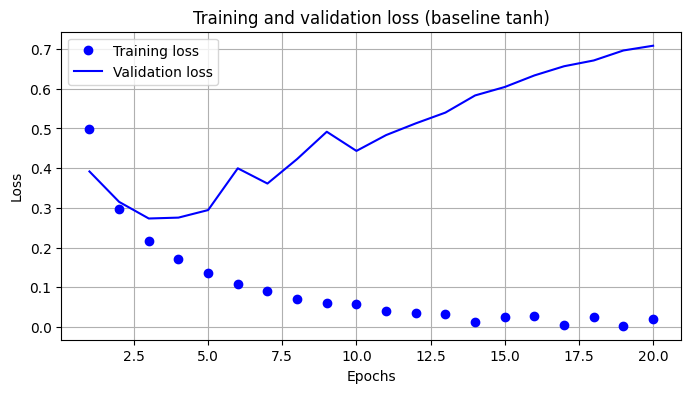

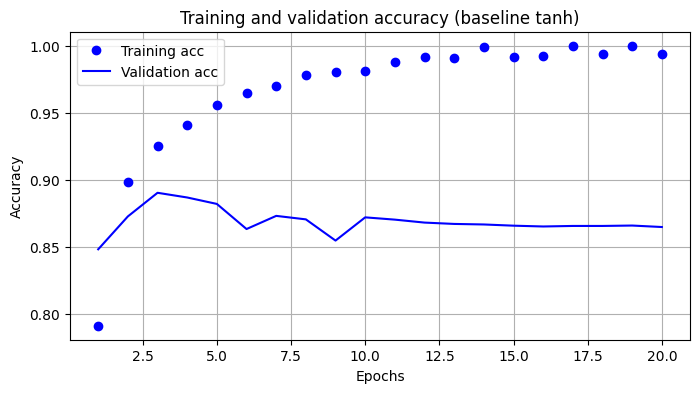

In [17]:
# Plotting training & validation curves
epochs = range(1, len(history_baseline["loss"]) + 1)
plt.figure(figsize=(8,4))
plt.plot(epochs, history_baseline["loss"], "bo", label="Training loss")
plt.plot(epochs, history_baseline["val_loss"], "b",  label="Validation loss")
plt.title("Training and validation loss (baseline tanh)")
plt.xlabel("Epochs"); plt.ylabel("Loss"); plt.legend(); plt.grid(True)
plt.savefig("images/baseline_loss_tanh.png"); plt.show()


plt.figure(figsize=(8,4))
plt.plot(epochs, history_baseline["accuracy"], "bo", label="Training acc")
plt.plot(epochs, history_baseline["val_accuracy"], "b",  label="Validation acc")
plt.title("Training and validation accuracy (baseline tanh)")
plt.xlabel("Epochs"); plt.ylabel("Accuracy"); plt.legend(); plt.grid(True)
plt.savefig("images/baseline_acc_tanh.png"); plt.show()


In [18]:
# ✅ Retrainning final model for best epoch
best_epoch = np.argmax(history_baseline["val_accuracy"]) + 1
print("Best epoch (baseline tanh):", best_epoch)

final_model = build_model(hidden_layers=2, units=16, activation="tanh")
final_model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
final_model.fit(x_train, y_train, epochs=best_epoch, batch_size=512, verbose=2)

results = final_model.evaluate(x_test, y_test, verbose=2)
print("Test loss, Test accuracy:", results)


Best epoch (baseline tanh): 3
Epoch 1/3
49/49 - 3s - 63ms/step - accuracy: 0.8198 - loss: 0.4432
Epoch 2/3
49/49 - 2s - 36ms/step - accuracy: 0.9066 - loss: 0.2555
Epoch 3/3
49/49 - 2s - 36ms/step - accuracy: 0.9270 - loss: 0.1971
782/782 - 3s - 4ms/step - accuracy: 0.8859 - loss: 0.2807
Test loss, Test accuracy: [0.28068244457244873, 0.8858799934387207]


In [19]:
# Predictions & confusion matrix
y_prob = final_model.predict(x_test, verbose=0).flatten()
y_pred = (y_prob > 0.5).astype("int32")
cm = confusion_matrix(y_test.astype("int32"), y_pred)
print("Confusion matrix:\n", cm)
print("\nClassification report:\n", classification_report(y_test.astype("int32"), y_pred, digits=4))


Confusion matrix:
 [[11038  1462]
 [ 1391 11109]]

Classification report:
               precision    recall  f1-score   support

           0     0.8881    0.8830    0.8856     12500
           1     0.8837    0.8887    0.8862     12500

    accuracy                         0.8859     25000
   macro avg     0.8859    0.8859    0.8859     25000
weighted avg     0.8859    0.8859    0.8859     25000



In [20]:
# ✅ Required experiments
configs = [
    {"id":"1layer_16", "hidden_layers":1, "units":16, "activation":"tanh", "loss":"binary_crossentropy", "dropout":0.0,  "l2":0.0},
    {"id":"3layer_16", "hidden_layers":3, "units":16, "activation":"tanh", "loss":"binary_crossentropy", "dropout":0.0,  "l2":0.0},
    {"id":"2layer_32", "hidden_layers":2, "units":32, "activation":"tanh", "loss":"binary_crossentropy", "dropout":0.0,  "l2":0.0},
    {"id":"2layer_64", "hidden_layers":2, "units":64, "activation":"tanh", "loss":"binary_crossentropy", "dropout":0.0,  "l2":0.0},
    {"id":"2layer_mse", "hidden_layers":2, "units":16, "activation":"tanh", "loss":"mse", "dropout":0.0,  "l2":0.0},
    {"id":"2layer_dropout", "hidden_layers":2, "units":16, "activation":"tanh", "loss":"binary_crossentropy", "dropout":0.5,  "l2":0.0},
    {"id":"2layer_l2", "hidden_layers":2, "units":16, "activation":"tanh", "loss":"binary_crossentropy", "dropout":0.0,  "l2":0.001},
]

results_list = []
for cfg in configs:
    print("\nRunning config:", cfg["id"])
    model_cfg = build_model(hidden_layers=cfg["hidden_layers"],
                            units=cfg["units"],
                            activation=cfg["activation"],
                            l2_weight=cfg["l2"],
                            dropout_rate=cfg["dropout"])
    model_cfg.compile(optimizer="rmsprop", loss=cfg["loss"], metrics=["accuracy"])
    hist = model_cfg.fit(partial_x_train, partial_y_train, epochs=10, batch_size=512,
                         validation_data=(x_val, y_val), verbose=0)
    best_val_acc = max(hist.history["val_accuracy"])
    best_epoch = np.argmax(hist.history["val_accuracy"]) + 1
    model_cfg_full = build_model(hidden_layers=cfg["hidden_layers"],
                                 units=cfg["units"],
                                 activation=cfg["activation"],
                                 l2_weight=cfg["l2"],
                                 dropout_rate=cfg["dropout"])
    model_cfg_full.compile(optimizer="rmsprop", loss=cfg["loss"], metrics=["accuracy"])
    model_cfg_full.fit(x_train, y_train, epochs=best_epoch, batch_size=512, verbose=0)
    test_loss, test_acc = model_cfg_full.evaluate(x_test, y_test, verbose=0)
    results_list.append({
        "config": cfg["id"],
        "hidden_layers": cfg["hidden_layers"],
        "units": cfg["units"],
        "activation": cfg["activation"],
        "loss": cfg["loss"],
        "dropout": cfg["dropout"],
        "l2": cfg["l2"],
        "best_val_acc": float(best_val_acc),
        "best_epoch": int(best_epoch),
        "test_acc": float(test_acc),
        "test_loss": float(test_loss),
    })
    print("  best_val_acc=%.4f, best_epoch=%d, test_acc=%.4f" % (best_val_acc, best_epoch, test_acc))

results_df = pd.DataFrame(results_list)
results_df.to_csv("images/assignment2_results.csv", index=False)
results_df



Running config: 1layer_16


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  best_val_acc=0.8883, best_epoch=4, test_acc=0.8860

Running config: 3layer_16
  best_val_acc=0.8850, best_epoch=4, test_acc=0.8599

Running config: 2layer_32
  best_val_acc=0.8881, best_epoch=3, test_acc=0.8841

Running config: 2layer_64


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  best_val_acc=0.8859, best_epoch=3, test_acc=0.8801

Running config: 2layer_mse
  best_val_acc=0.8894, best_epoch=3, test_acc=0.8868

Running config: 2layer_dropout
  best_val_acc=0.8884, best_epoch=6, test_acc=0.8809

Running config: 2layer_l2
  best_val_acc=0.8857, best_epoch=4, test_acc=0.8665


,config,hidden_layers,units,activation,loss,dropout,l2,best_val_acc,best_epoch,test_acc,test_loss
0,1layer_16,1,16,tanh,binary_crossentropy,0.0,0.000,0.8883,4,0.88604,0.279588
1,3layer_16,3,16,tanh,binary_crossentropy,0.0,0.000,0.8850,4,0.85992,0.376755
2,2layer_32,2,32,tanh,binary_crossentropy,0.0,0.000,0.8881,3,0.88412,0.288329
3,2layer_64,2,64,tanh,binary_crossentropy,0.0,0.000,0.8859,3,0.88012,0.303455
4,2layer_mse,2,16,tanh,mse,0.0,0.000,0.8894,3,0.88684,0.083732
5,2layer_dropout,2,16,tanh,binary_crossentropy,0.5,0.000,0.8884,6,0.88092,0.324689
6,2layer_l2,2,16,tanh,binary_crossentropy,0.0,0.001,0.8857,4,0.86652,0.389535
